In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow_probability.substrates import numpy as tfp
from cmdstanpy import CmdStanModel, set_cmdstan_path
import arviz as az

In [2]:
Y = pd.read_csv("../Datasets/Dataset_120.csv")
Y['Count_120'] = pd.to_numeric(Y['Count_120']).astype('Int64')

In [3]:
X = pd.read_csv("../Datasets/variables_to_select.csv")

In [4]:
rows_to_drop_Y = Y[Y['Count_120'].isna()].index

# Remove corresponding rows from dataset X
X = X.drop(index=rows_to_drop_Y)
Y = Y.drop(index=rows_to_drop_Y)

# If you want to reset the index after dropping rows
X = X.reset_index(drop=True)
Y = Y.reset_index(drop=True)

In [5]:
Y.head

<bound method NDFrame.head of       Count_120  idSensore  Year  Month
0             4       5707  2010      4
1             8       5707  2010      5
2            16       5707  2010      6
3            25       5707  2010      7
4            12       5707  2010      8
...         ...        ...   ...    ...
3835         16      12020  2022      6
3836         28      12020  2022      7
3837          6      12020  2022      8
3838          3      12020  2022      9
3839          0      12020  2022     10

[3840 rows x 4 columns]>

In [7]:
stations = Y['idSensore']
years = Y['Year'] - 2009
unique_values = sorted(set(stations))
mapping_dict = {value: index + 1 for index, value in enumerate(unique_values)}
transformed_stations = [mapping_dict[value] for value in stations]
stations_original = stations
stations = transformed_stations

In [32]:
base_model = """

data {
  int<lower=1> N; // Number of observations
  int<lower=1> P; // Covariate number

  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
}

parameters {
  vector[P] beta; // Coefficients for predictors
}

transformed parameters {
    vector[N] lambda;
    vector[N] fix_eff;

    fix_eff = X * beta;

    lambda = exp(fix_eff);
}

model {

  beta ~ normal(0, 2);
  y[1:N] ~ poisson(lambda[1:N]);

}
generated quantities{
 vector[N] log_lik;
 for(i in 1:N){
   log_lik [ i ] = poisson_lpmf (y [ i ] |lambda[i]) ;
}
}

"""

stan_file = "./stan/base.stan"

with open(stan_file, "w") as f:
    print(base_model, file=f)

model_base = CmdStanModel(stan_file=stan_file)

19:10:47 - cmdstanpy - INFO - compiling stan file C:\Users\leoma\OneDrive\DOCUME~1\PoliMi\BAYESI~1\BAYESI~1\main\Modello\stan\base.stan to exe file C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan\base.exe
19:11:12 - cmdstanpy - INFO - compiled model executable: C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan\base.exe


In [9]:
data = {
    "N": len(Y),
    "P": X.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": stations,
    "year": years,
    "y": Y['Count_120'],
    "X": X
}


fit_base = model_base.sample(data=data, chains=4, parallel_chains=4, 
    iter_warmup=300, iter_sampling=200)
posterior_base_az = az.from_cmdstanpy(fit_base)

18:52:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:52:15 - cmdstanpy - INFO - CmdStan done processing.


C:\Users\leoma\AppData\Local\Temp\ipykernel_796\3019062433.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


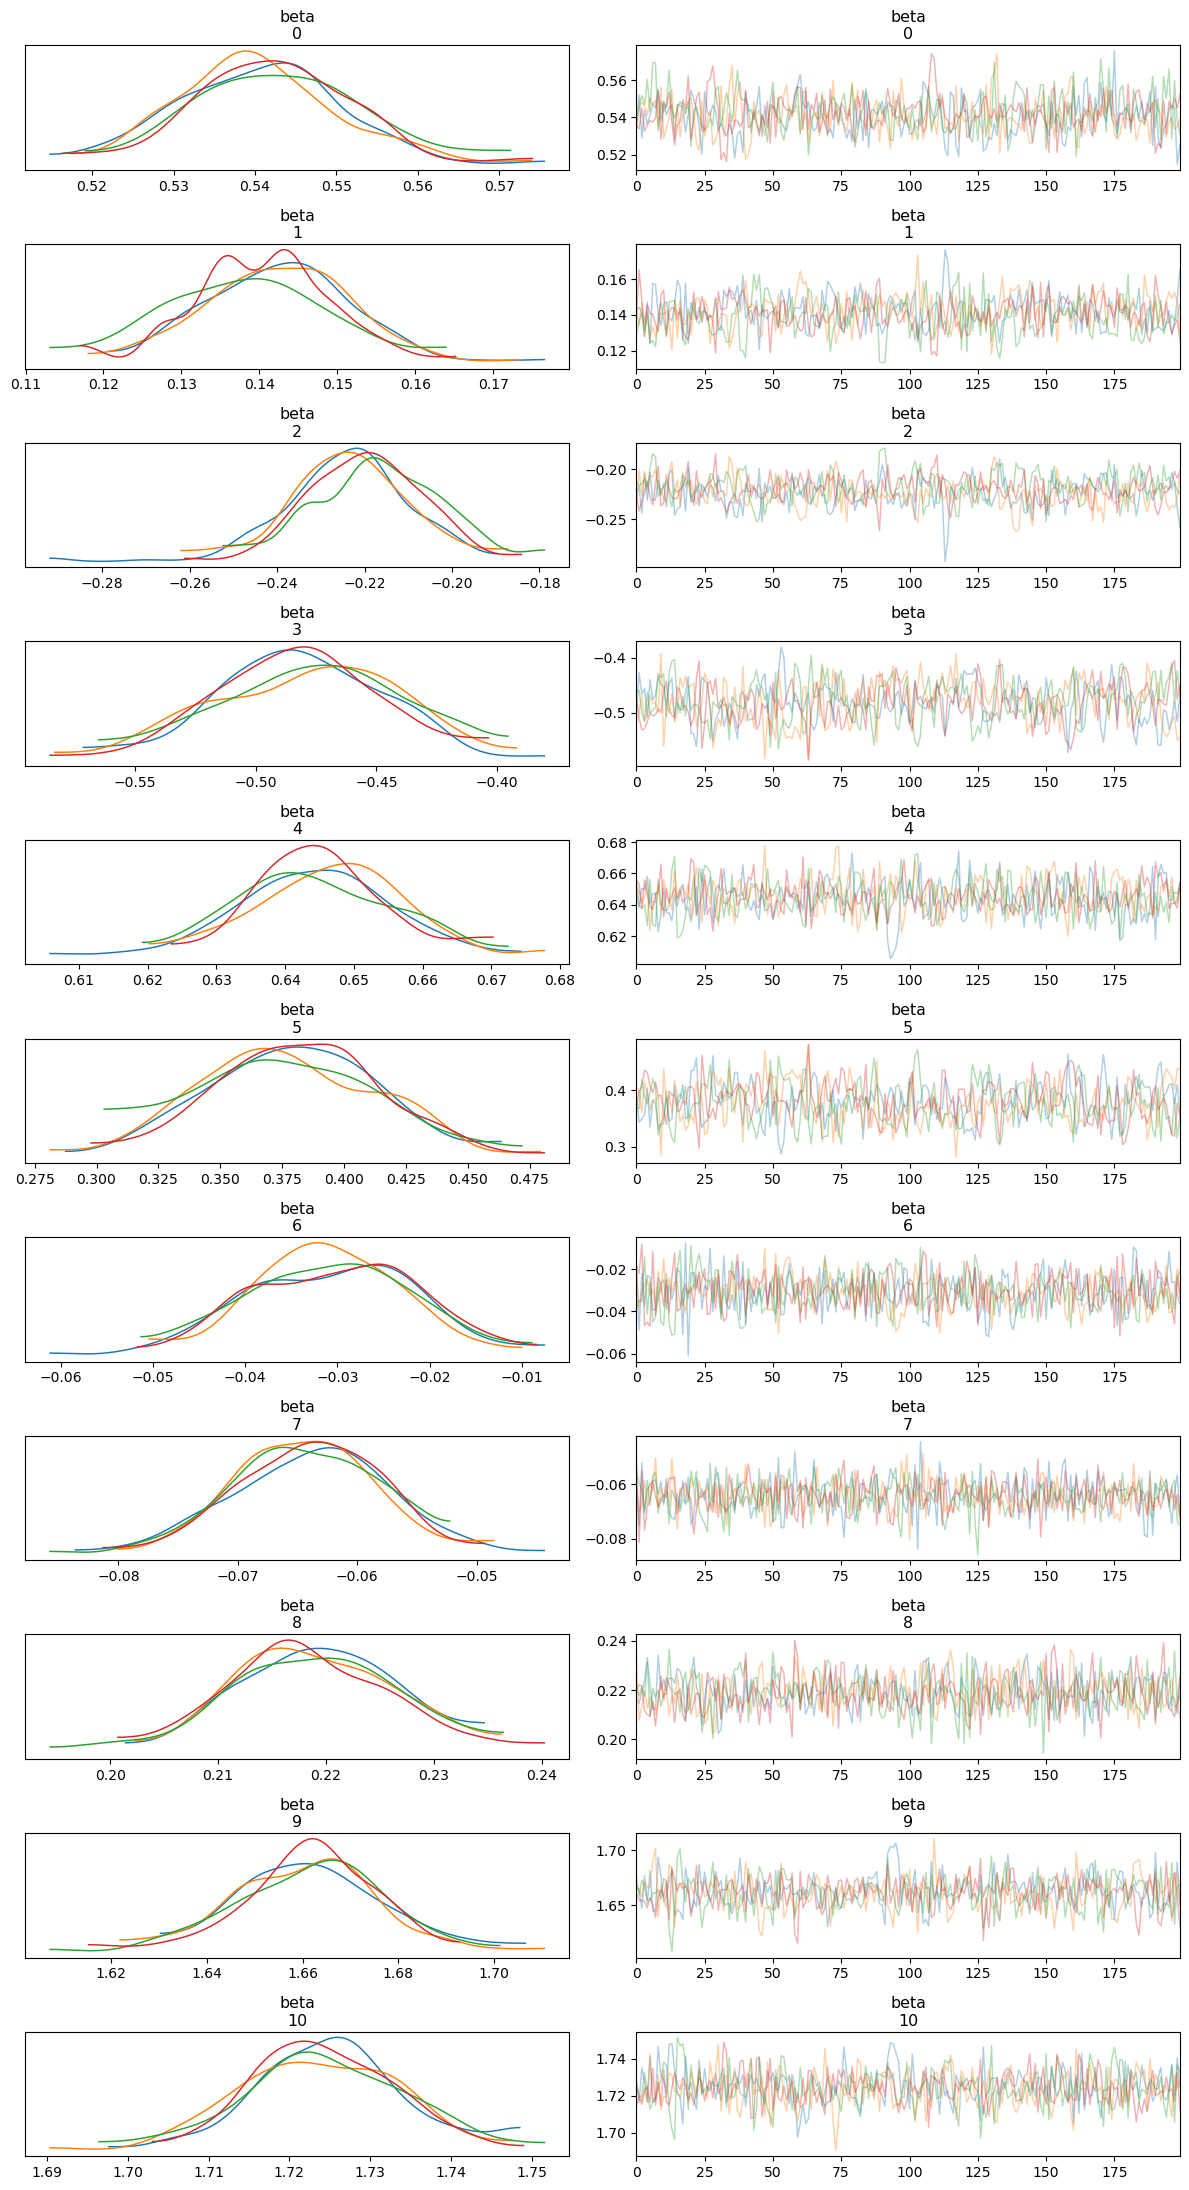

In [79]:
az.plot_trace(posterior_base_az, var_names = ['beta'], compact=False)
plt.tight_layout()
plt.show()

In [80]:
log_lik = fit.stan_variable("log_lik")
print(type(log_lik))

<class 'numpy.ndarray'>


In [10]:
# Crea un oggetto InferenceData contenente log_lik
#inference_data = az.from_cmdstanpy(fit, log_likelihood={"log_lik": log_lik})

# Calcola e stampa WAIC
waic_result = az.waic(fit_base, var_name="log_lik")
print("WAIC: ", waic_result)

# Calcola e stampa LOO
loo_result = az.loo(fit_base, var_name="log_lik")
print("LOO: ", loo_result)

C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC:  Computed from 800 posterior samples and 3840 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -13593.04   235.55
p_waic       41.08        -

There has been a warning during the calculation. Please check the results.
LOO:  Computed from 800 posterior samples and 3840 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -13593.26   235.55
p_loo       41.30        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3840  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



Now we remove some variables, through two methods:\
    1. Variable selection through **SSVS**\
    2. Hard shrinkage in the posterior of the betas   
    
The code for the SSVS is on R in its folder, while the hard shrinkage will be in this file.

Given the SSVS paradigm, the covariates to remove are *max_consecutive_highwind_days*, *Densità*, *count_highwind*

In [ ]:
##Code for hard shrinkage, hopefully same result

In [11]:
X = X.drop(columns=['max_consecutive_highwind_days', 'Densità', 'count_highwind'])

In [15]:
var_sel_model = """

data {
  int<lower=1> N; // Number of observations
  int<lower=1> P; // Covariate number

  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
}

parameters {
  vector[P] beta; // Coefficients for predictors
}

transformed parameters {
    vector[N] lambda;
    vector[N] fix_eff;

    fix_eff = X * beta;

    lambda = exp(fix_eff);
}

model {

  beta ~ normal(0, 2);
  y[1:N] ~ poisson(lambda[1:N]);

}
generated quantities{
 vector[N] log_lik;
 for(i in 1:N){
   log_lik [ i ] = poisson_lpmf (y [ i ] |lambda[i]) ;
}
}

"""

stan_file = "./stan/var_sel.stan"

with open(stan_file, "w") as f:
    print(var_sel_model, file=f)

model_var_sel = CmdStanModel(stan_file=stan_file)

18:53:40 - cmdstanpy - INFO - compiling stan file C:\Users\leoma\OneDrive\DOCUME~1\PoliMi\BAYESI~1\BAYESI~1\main\Modello\var_sel.stan to exe file C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\var_sel.exe
18:54:05 - cmdstanpy - INFO - compiled model executable: C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\var_sel.exe


In [17]:
data = {
    "N": len(Y),
    "P": X.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": stations,
    "year": years,
    "y": Y['Count_120'],
    "X": X
}


fit_var_sel = model_var_sel.sample(data=data, chains=4, parallel_chains=4, 
    iter_warmup=300, iter_sampling=200)
posterior_var_sel_az = az.from_cmdstanpy(fit_var_sel)

18:54:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:54:39 - cmdstanpy - INFO - CmdStan done processing.


C:\Users\leoma\AppData\Local\Temp\ipykernel_796\3019062433.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


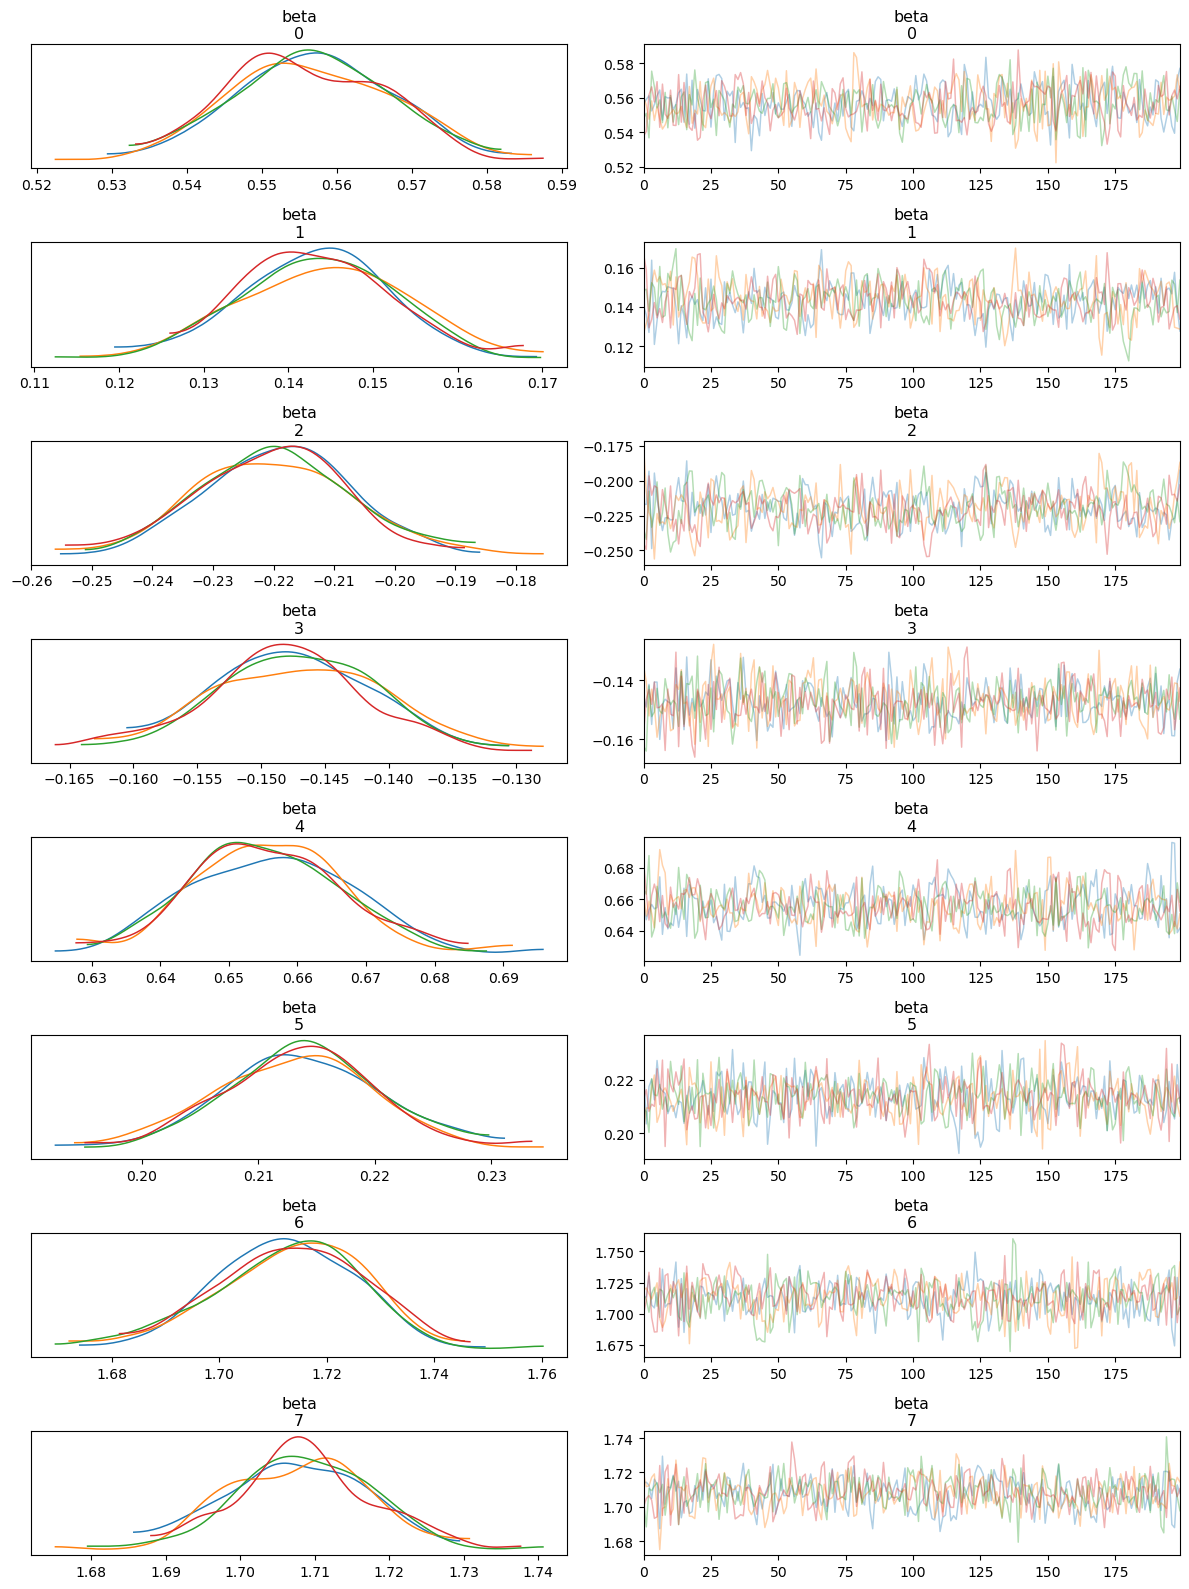

In [67]:
az.plot_trace(posterior_var_sel_az, var_names = ['beta'], compact=False)
plt.tight_layout()
plt.show()

In [68]:
log_lik = fit.stan_variable("log_lik")
print(type(log_lik))

<class 'numpy.ndarray'>


In [18]:
# Crea un oggetto InferenceData contenente log_lik
#inference_data = az.from_cmdstanpy(fit, log_likelihood={"log_lik": log_lik})

# Calcola e stampa WAIC
waic_result = az.waic(fit_var_sel, var_name="log_lik")
print("WAIC: ", waic_result)

# Calcola e stampa LOO
loo_result = az.loo(fit_var_sel, var_name="log_lik")
print("LOO: ", loo_result)

C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC:  Computed from 800 posterior samples and 3840 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -13696.95   240.23
p_waic       33.63        -

There has been a warning during the calculation. Please check the results.
LOO:  Computed from 800 posterior samples and 3840 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -13697.15   240.24
p_loo       33.82        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3839  100.0%
 (0.5, 0.7]   (ok)          1    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



For both our models there are problems and things that can be improved, namely for the 120 threshold model, some outliers make the prediction very biased while for the 180 threshold the zero inflation is a problem we have to account for.
The next code is made for removing these problems and hopefully get a better fit

In [ ]:
#Code for improve the fit

*Next step:*\
We add the factor accounting for different years.

In [19]:
year_model = """

data {
  int<lower=1> N; // Number of observations
  int<lower=1> P; // Covariate number
  int<lower=1> nyears;

  array[N] int<lower=1> year;

  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
}

parameters {
  vector[P] beta; // Coefficients for predictors
  vector[nyears] xi; // Random effects for years
}

transformed parameters {
    vector[N] lambda;
    vector[N] fix_eff;
    vector[N] intercept;

    fix_eff = X * beta;
    intercept = xi[year];

    lambda = exp(fix_eff + intercept);
}

model {

  beta ~ normal(0, 2);
  y[1:N] ~ poisson(lambda[1:N]);

  xi ~ normal(0, 2);
}
generated quantities{
 vector[N] log_lik;
 for(i in 1:N){
   log_lik [ i ] = poisson_lpmf (y [ i ] |lambda[i]) ;
}
}

"""

stan_file = "./stan/year.stan"

with open(stan_file, "w") as f:
    print(year_model, file=f)

model_year = CmdStanModel(stan_file=stan_file)

18:54:46 - cmdstanpy - INFO - compiling stan file C:\Users\leoma\OneDrive\DOCUME~1\PoliMi\BAYESI~1\BAYESI~1\main\Modello\year.stan to exe file C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\year.exe
18:55:11 - cmdstanpy - INFO - compiled model executable: C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\year.exe


In [20]:
data = {
    "N": len(Y),
    "P": X.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": stations,
    "year": years,
    "y": Y['Count_120'],
    "X": X
}


fit_years = model_year.sample(data=data, chains=4, parallel_chains=4, 
    iter_warmup=300, iter_sampling=200)
posterior_year_az = az.from_cmdstanpy(fit_years)

18:55:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:55:24 - cmdstanpy - INFO - CmdStan done processing.


C:\Users\leoma\AppData\Local\Temp\ipykernel_796\3019062433.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


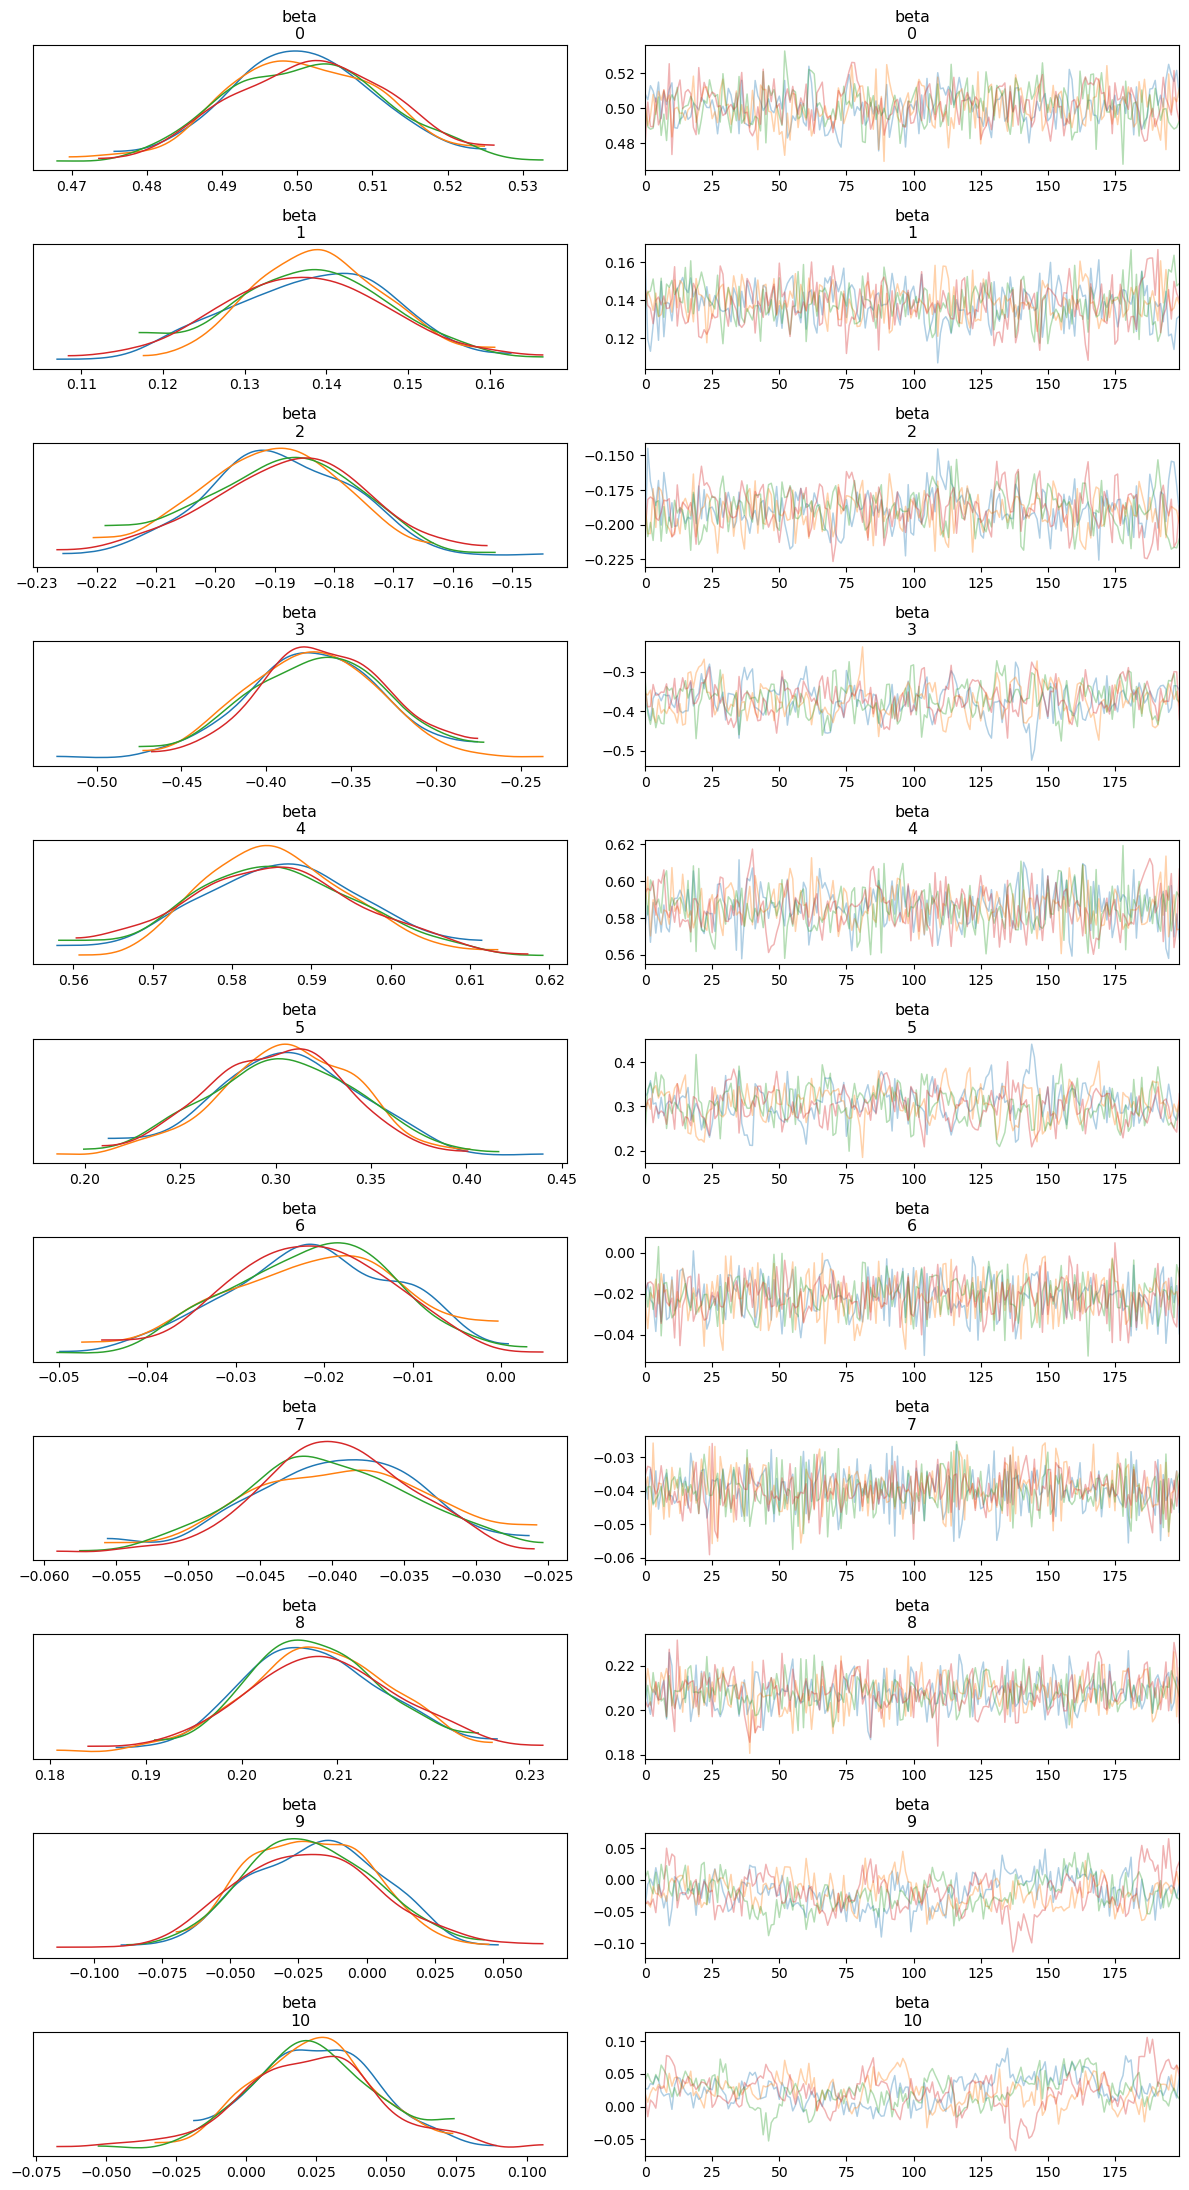

In [26]:
az.plot_trace(posterior_years_az, var_names = ['beta'], compact=False)
plt.tight_layout()
plt.show()

In [35]:
log_lik = fit.stan_variable("log_lik")
print(type(log_lik))

<class 'numpy.ndarray'>


In [21]:
# Crea un oggetto InferenceData contenente log_lik
#inference_years = az.from_cmdstanpy(fit, log_likelihood={"log_lik": log_lik})

# Calcola e stampa WAIC
waic_result = az.waic(fit_years, var_name="log_lik")
print("WAIC: ", waic_result)

# Calcola e stampa LOO
loo_result = az.loo(fit_years, var_name="log_lik")
print("LOO: ", loo_result)

C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC:  Computed from 800 posterior samples and 3840 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -11195.14   116.21
p_waic       52.78        -

There has been a warning during the calculation. Please check the results.
LOO:  Computed from 800 posterior samples and 3840 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -11195.40   116.22
p_loo       53.04        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3840  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



After this upgrade, we account for the differences in the *stations* factor.

In [22]:
station_model = """

data {
  int<lower=1> N; // Number of observations
  int<lower=1> P; // Covariate number
  int<lower=1> nyears;
  int<lower=1> nstations;

  array[N] int<lower=1> year;
  array[N] int<lower=1> stations;

  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
}

parameters {
  vector[P] beta; // Coefficients for predictors
  vector[nyears] xi; // Random effects for years
  vector[nstations] eta;//For the stations
}

transformed parameters {
    vector[N] lambda;
    vector[N] fix_eff;
    vector[N] intercept;

    fix_eff = X * beta;
    intercept = xi[year] + eta[stations];

    lambda = exp(fix_eff + intercept);
}

model {

  beta ~ normal(0, 2);
  y[1:N] ~ poisson(lambda[1:N]);

  xi ~ normal(0, 2);
  eta ~ normal(0, 2);
}
generated quantities{
 vector[N] log_lik;
 for(i in 1:N){
   log_lik [ i ] = poisson_lpmf (y [ i ] |lambda[i]) ;
}
}

"""

stan_file = "./stan/station.stan"

with open(stan_file, "w") as f:
    print(station_model, file=f)

model_station = CmdStanModel(stan_file=stan_file)

18:55:34 - cmdstanpy - INFO - compiling stan file C:\Users\leoma\OneDrive\DOCUME~1\PoliMi\BAYESI~1\BAYESI~1\main\Modello\station.stan to exe file C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\station.exe
18:56:00 - cmdstanpy - INFO - compiled model executable: C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\station.exe


In [23]:
data = {
    "N": len(Y),
    "P": X.shape[1],
    "nyears": 13,
    "nstations": 45,
    "stations": stations,
    "year": years,
    "y": Y['Count_120'],
    "X": X
}


fit_stations = model_station.sample(data=data, chains=4, parallel_chains=4, 
    iter_warmup=300, iter_sampling=200)
posterior_station_az = az.from_cmdstanpy(fit_stations)

18:56:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:57:41 - cmdstanpy - INFO - CmdStan done processing.


18:57:42 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 16 iterations at max treedepth (8.0%)
	Chain 2 had 2 iterations at max treedepth (1.0%)
	Chain 3 had 5 iterations at max treedepth (2.5%)
	Chain 4 had 43 iterations at max treedepth (21.5%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


C:\Users\leoma\AppData\Local\Temp\ipykernel_796\3019062433.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


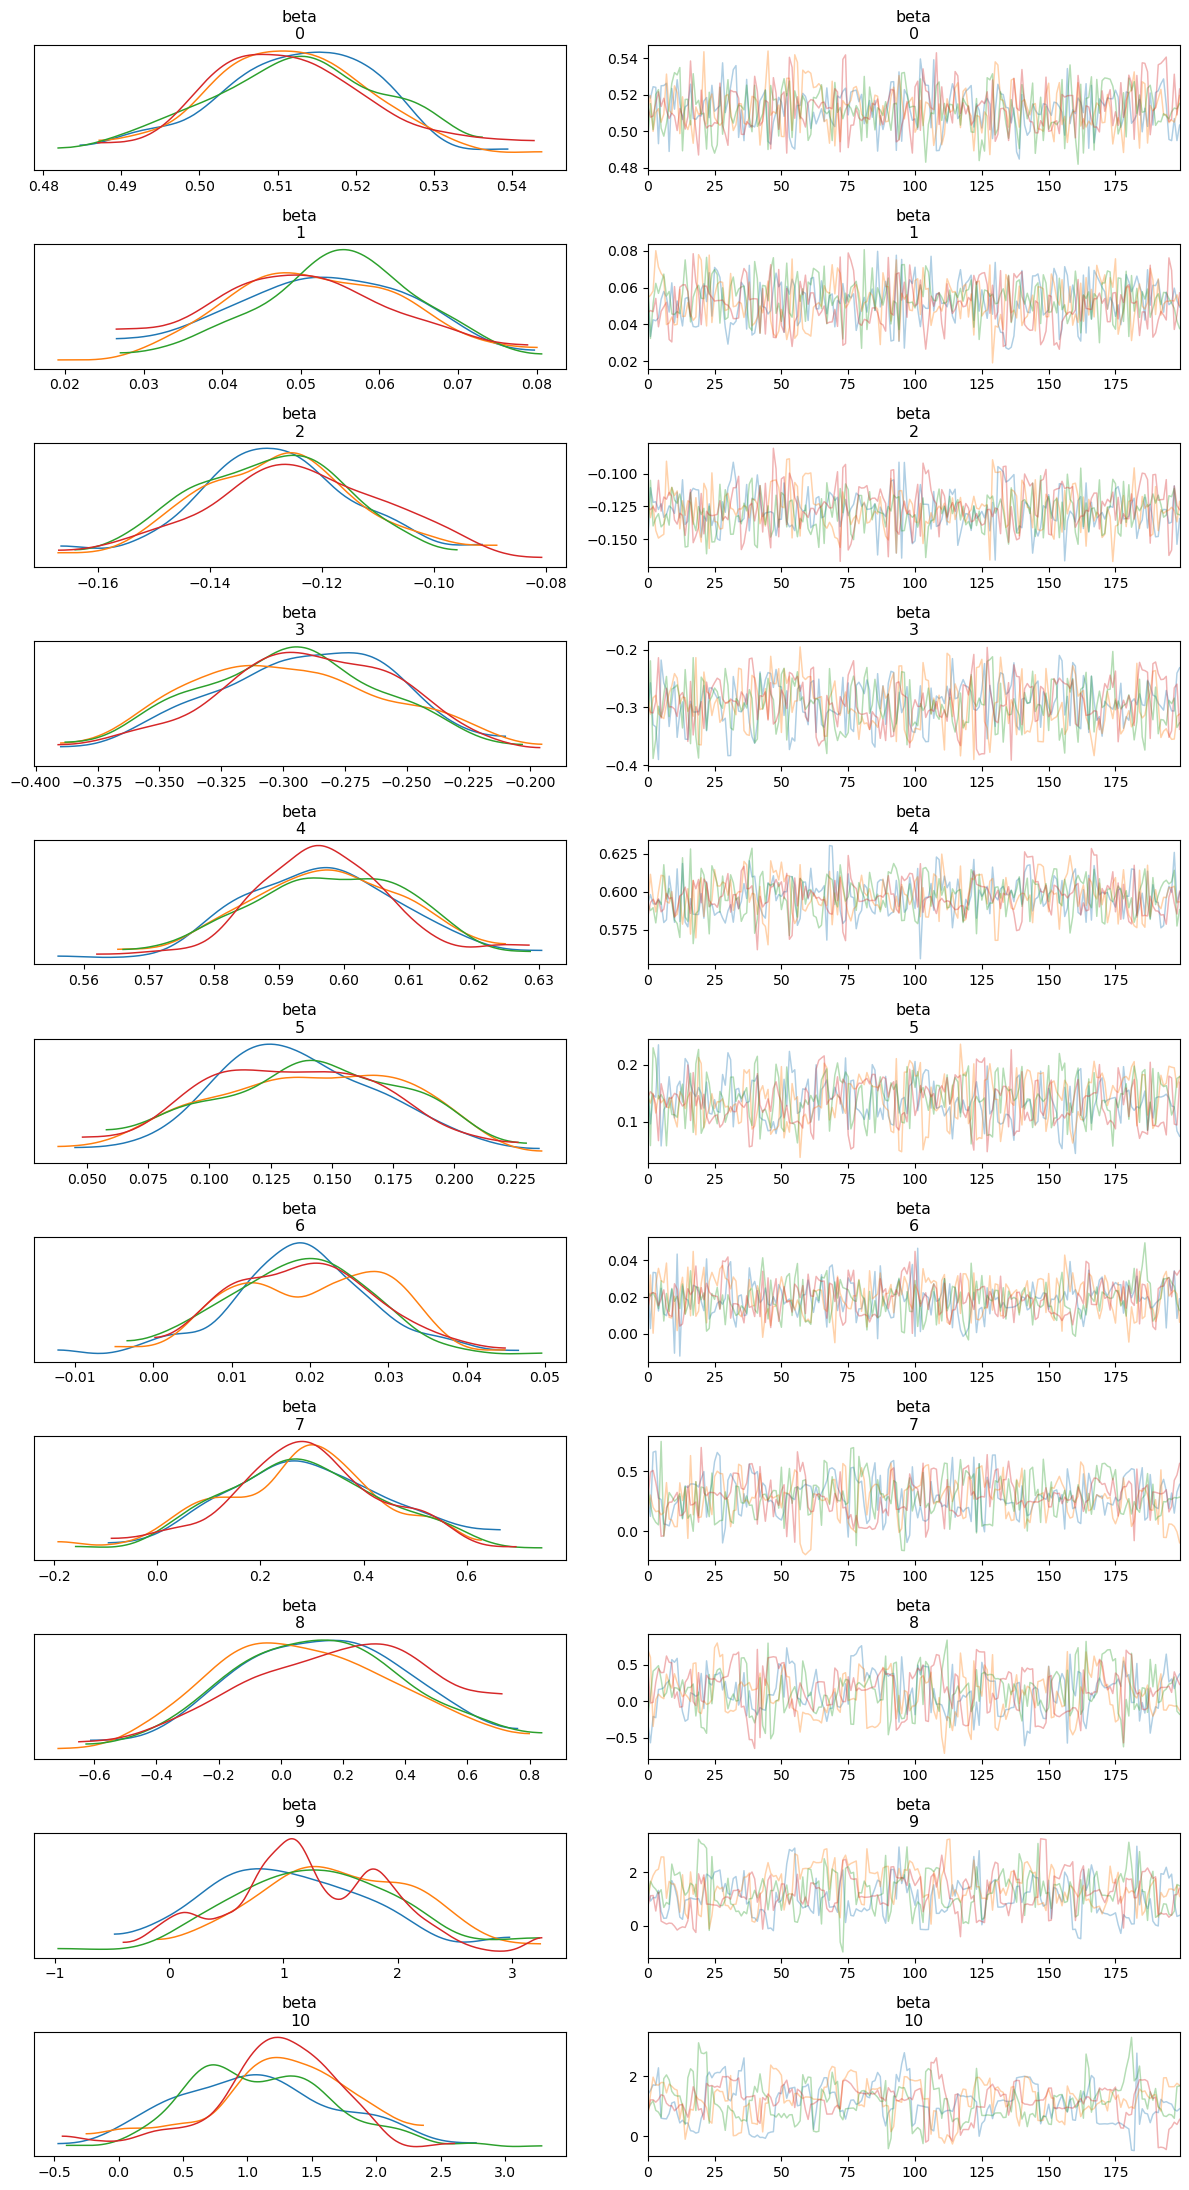

In [49]:
az.plot_trace(posterior_station_az, var_names = ['beta'], compact=False)
plt.tight_layout()
plt.show()

In [50]:
log_lik = fit_stations.stan_variable("log_lik")
print(type(log_lik))

<class 'numpy.ndarray'>


In [25]:
# Crea un oggetto InferenceData contenente log_lik
#inference_stations = az.from_cmdstanpy(fit_stations, log_likelihood={"log_lik": log_lik})

# Calcola e stampa WAIC
waic_result = az.waic(fit_stations, var_name="log_lik")
print("WAIC: ", waic_result)

# Calcola e stampa LOO
loo_result = az.loo(fit_stations, var_name="log_lik")
print("LOO: ", loo_result)

C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC:  Computed from 800 posterior samples and 3840 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -10106.57    86.29
p_waic      100.29        -

There has been a warning during the calculation. Please check the results.
LOO:  Computed from 800 posterior samples and 3840 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -10107.28    86.31
p_loo      101.00        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3839  100.0%
 (0.5, 0.7]   (ok)          1    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



## Space model

Now, we should take into account the spatial dependance of the model, through an appropriate space model (main folder with R files) and put again this ideas into this model.
#### First space model:
Account for the correlation in an exponential way.


In [26]:
#Space model
space_model = """

functions {
    #include "distance.stan"
}

data {
  int<lower=1> N; // Number of observations
  int<lower=1> P; // Covariate number
  int<lower=1> nyears;
  int<lower=1> nstations;

  array[N] int<lower=1> year;
  array[N] int<lower=1> stations;

  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
  real phi;
  matrix[nstations, nstations] distances;
}

transformed data {
    matrix[nstations,nstations] H = exp(-(phi^2) * distances);

}

parameters {
  vector[P] beta; // Coefficients for predictors
  vector[nyears] xi; // Random effects for years
  vector[nstations] eta;//For the stations
}

transformed parameters {
    vector[N] lambda;
    vector[N] fix_eff;
    vector[N] intercept;
    matrix[nstations,nstations] Sigma_s = H; //To be added the variance
    matrix[nstations,nstations] Lw = cholesky_decompose(Sigma_s);


    fix_eff = X * beta;
    intercept = xi[year] + eta[stations];

    lambda = exp(fix_eff + intercept);
}

model {

  beta ~ normal(0, 2);
  y[1:N] ~ poisson(lambda[1:N]);

  xi ~ normal(0, 2);
  eta ~ multi_normal_cholesky(rep_vector(0, nstations), H);
}
generated quantities{
 vector[N] log_lik;
 for(i in 1:N){
   log_lik [ i ] = poisson_lpmf (y [ i ] |lambda[i]) ;
}
}

"""

stan_file = "./stan/space.stan"

with open(stan_file, "w") as f:
    print(space_model, file=f)

model_space = CmdStanModel(stan_file=stan_file)

18:58:11 - cmdstanpy - INFO - compiling stan file C:\Users\leoma\OneDrive\DOCUME~1\PoliMi\BAYESI~1\BAYESI~1\main\Modello\stan\space.stan to exe file C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan\space.exe
18:58:49 - cmdstanpy - INFO - compiled model executable: C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan\space.exe


In [27]:
phi = 62
distances = pd.read_csv("../Datasets/distances.csv", index_col=0)

In [29]:
data = {
    "N": len(Y),
    "P": X.shape[1],
    "nyears": 13,
    "nstations": 45,
    "stations": stations,
    "year": years,
    "y": Y['Count_120'],
    "X": X,
    "phi": phi,
    "distances": distances
}


fit_space = model_space.sample(data=data, chains=4, parallel_chains=4, 
    iter_warmup=300, iter_sampling=200)
posterior_space_az = az.from_cmdstanpy(fit_space)

18:58:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:01:03 - cmdstanpy - INFO - CmdStan done processing.


19:01:04 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 6 iterations at max treedepth (3.0%)
	Chain 2 had 5 iterations at max treedepth (2.5%)
	Chain 3 had 5 iterations at max treedepth (2.5%)
	Chain 4 had 7 iterations at max treedepth (3.5%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


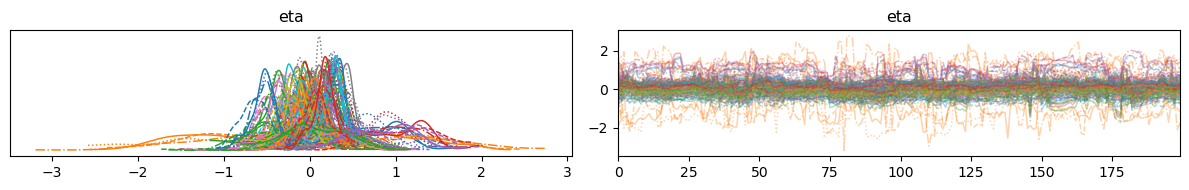

In [30]:
az.plot_trace(posterior_space_az, var_names = ['eta'], compact=True)
plt.tight_layout()
plt.show()

In [31]:
# Calcola e stampa WAIC
waic_result = az.waic(fit_space, var_name="log_lik")
print("WAIC: ", waic_result)

# Calcola e stampa LOO
loo_result = az.loo(fit_space, var_name="log_lik")
print("LOO: ", loo_result)

C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC:  Computed from 800 posterior samples and 3840 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -10107.58    86.38
p_waic      101.70        -

There has been a warning during the calculation. Please check the results.
LOO:  Computed from 800 posterior samples and 3840 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -10108.21    86.39
p_loo      102.32        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3840  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

